<font size="6"><strong><center>SPAM CLASSIFICATION<center></strong></font>

<font color="Purple"><font size="3"><b>Name: AASHIK BHARATH EGNYA VARAHAN</b></font><br>
<font color="Purple"><font size="3"><b>Student No.: R00182866</b></font>

In [1]:
import os
import re
import time
import operator
import itertools 
import pickle
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,f1_score,precision_recall_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sn

<font size="5"><strong>Imports</strong></font>

1. <b>os:</b> It allows to operate on underlying Operating System tasks
2. <b>re:</b> It is used for ridding the string from special and unwanted characters which have no meaning or feeling behind it such as "<", ">" etc
3. <b>time:</b> It is used to keep track of the execution time taken for complete process
4. <b>operator:</b> It is used to import a set of efficient functions corresponding to the intrinsic operators
5. <b>itertols:</b> It provides various functions that work on iterators to produce complex iterators
6. <b>pickle:</b> It converts a python object (list, dict, etc.) into a character stream and stores it in a file
7. <b>pandas:</b> It is used for data manipulation and analysis
8. <b>numpy:</b> It is used to perform scientific computing and data manipulation
9. <b>sklearn:</b> Scikit-learn is used for implementing machine learning algorithms, feature extractions and computing various scores of predicted models
10. <b>matplotlib:</b> pyplot is a collection of command style functions that make matplotlib work like MATLAB
11. <b>seaborn:</b> It is a data visualization library based on matplotlib, provides a high-level interface for drawing attractive and informative statistical graphics.

<font size="5"><strong>Reading the Files</strong></font>

In [2]:
def open_and_read_files(rootdir):
    ham_list=[]
    spam_list=[]

    for directories, subdirs, files in os.walk(rootdir):
        if (os.path.split(directories)[1]  == 'ham'):
            for filename in files:      
                with open(os.path.join(directories, filename), encoding="latin-1") as file:
                    file.seek(0)
                    first_char = file.read(1)
                    if not first_char:
                        continue
                    else:
                        file.seek(0)
                        data = file.read()
                        ham_list.append(data)

    for directories, subdirs, files in os.walk(rootdir):
        if (os.path.split(directories)[1]  == 'spam'):
            for filename in files:      
                with open(os.path.join(directories, filename), encoding="latin-1") as file:
                    file.seek(0)
                    first_char = file.read(1)
                    if not first_char:
                        continue
                    else:
                        file.seek(0)
                        data = file.read()
                        spam_list.append(data)

    return ham_list, spam_list

<li><b>@params rootdir:</b> It is the path of the directory where dataset is stored</li>
<li><b>@returns ham_list, spam_list:</b> It returns the list of ham and spam emails data</li>

The above code snippet reads the data from each and every file under ham and spam sub folders of Enron dataset.   
The emails read from these files are stored in separate designated lists (ham_list, spam_list).   
If the email is found to be null, then that particular email is discarded and will not be stored to the list.

<font size="5"><strong>Cleaning the Data</strong></font>

In [3]:
def clean_list(ham_list, spam_list):
    ham_cleaned_list=[]
    spam_cleaned_list=[]
    
    for i in ham_list:
        the_clean_email = re.sub(r"[\;\?\<\>\,\"\|\:\.\`\~\{\}\\\/@$\%\[\]\(\)\^\-\+\&#\*\!\_\=]*", "", i)
        the_clean_email.strip()
        ham_cleaned_list.append(the_clean_email)
    
    for j in spam_list:
        the_clean_email = re.sub(r"[\;\?\<\>\,\"\|\:\.\`\~\{\}\\\/@$\%\[\]\(\)\^\-\+\&#\*\!\_\=]*", "", j)
        the_clean_email.strip()
        spam_cleaned_list.append(the_clean_email)
    
    return ham_cleaned_list, spam_cleaned_list

<li><b>@params ham_list, spam_list:</b> It stores the list of ham and spam emails data</li>
<li><b>@returns ham_cleaned_list, spam_cleaned_list:</b> It returns the cleaned data after removing unwanted special characters and white spaces</li>
    
Unnecessary characters and white spaces are removed from emails.
The cleaned email data is stored in separate lists.

<font size="5"><strong>Removing Duplicates</strong></font>

In [4]:
def remove_duplicates(ham_cleaned_list, spam_cleaned_list):
    ham_unique = set(ham_cleaned_list)
    ham_unique_list = list(ham_unique)
    
    spam_unique = set(spam_cleaned_list)
    spam_unique_list = list(spam_unique)
    
    return ham_unique_list, spam_unique_list

<li><b>@params ham_cleaned_list, spam_cleaned_list:</b> It stores the cleaned data after removing unwanted special characters and white spaces</li>
<li><b>@returns ham_processed_list, spam_processed_list:</b> It returns unique list of both ham and spam emails</li>
    
Duplicate emails are removed from both the list using <b>set</b> method

<font size="5"><strong>Converts into DataFrame</strong></font>

In [5]:
def convert_as_dataframe(ham_list, spam_list):
    data=[]
    for i in ham_list:
        message_ham = re.sub(r"\n", " ", i)
        data.append({'message':message_ham, 'class': 'Ham'})

    for j in spam_list:
        message_spam = re.sub(r"\n", " ", j)
        data.append({'message':message_spam, 'class': 'Spam'})
        
    emails_df = pd.DataFrame(data)
    
    return emails_df

<li><b>@params ham_list, spam_list:</b> It stores the unique list of both ham and spam emails</li>
<li><b>@return emails_df:</b> It returns the email messages and its class as a pandas dataframe</li>

The delimiter <b>"\n"</b> is replaced with a space.  
Each email message is appended to a list with its class type.  
The final list is converted into a pandas dataframe for further processing

<font size="5"><strong>Train/Test Data Split</strong></font>

In [6]:
def split_data(emails_df):
    # Categorizes spam as 0 and ham as 1
    emails_df.loc[emails_df["class"] == 'Ham', "class",] = 1
    emails_df.loc[emails_df["class"] == 'Spam', "class",] = 0
    
    # Dataframe is subset as message and class
    df_message = emails_df['message']
    df_class = emails_df['class']
    
    message_train, message_test, class_train, class_test = train_test_split(df_message, df_class, train_size=0.7, test_size=0.3, random_state=866, shuffle=True)
    
    return message_train, message_test, class_train, class_test

<li><b>@param emails_df:</b> It stores the email messages and its class as a pandas dataframe</li>
<li><b>@returns message_train, message_test, class_train, class_test:</b> It returns the classified training and testing data of email messages and its corresponding class</li>
    
The above function categorizes spam and ham data as numerical values 0 & 1.  
The dataframe is then subset into separate series message and class.  
Using <b>train_test_split</b> method from Scikit learn package, the dataset is splitted as train and test dataset in the ratio of <b>0.7:0.3</b>


<font size="5"><strong>Feature Extraction</strong></font>

In [7]:
def feature_extraction(message_train, message_test):
    # "subject" is added to the list of stop_words
    my_stop_words = ENGLISH_STOP_WORDS.union(["subject"])
    
    # feature extraction
    vec= TfidfVectorizer(min_df=2, encoding='utf-8', stop_words=my_stop_words, analyzer='word')
    
    message_train_Feature = vec.fit_transform(message_train)
    message_test_Feature = vec.transform(message_test)
    
    return message_train_Feature, message_test_Feature

<li><b>@param message_train, message_test:</b> It stores the training and testing data of email messages</li>
<li><b>@returns message_train_Feature, message_test_Feature:</b> It returns TF-IDF features of email messages from both ham and spam data</li>
    
The objective of this function is to extract TD-IDF features from the email messages of both train and test data.
- <b>min_df:</b> This parameter is used to set a threshold to ignore terms that occur lower than the given threshold.  
- <b>encoding:</b> This parameter decides the type of encoding used to decode.
- <b>stop_words:</b> This parameter is used to remove stop words from the features. Here, <b>"subject"</b> is added in addition to the existing list of stop words since it is present in both ham and spam emails frequently
- <b>analyzer:</b> This parameter decides whether the feature should be made of word or character n-grams
    
The stop_words are introduced to further improve the anaytics. The other parameters are all set to default.


<font size="5"><strong>Exploratory Data Analysis</strong></font>

In [8]:
def eda(message_train, class_train):
    # Creates new lists to append Ham and Spam Emails from training dataset
    list_ham = []
    list_spam = []
    
    train_df = pd.concat([message_train, class_train], axis=1)
    
    for i, j in train_df.iterrows():
        if j['class']==1:
            list_ham.append(j['message'])
        else:
            list_spam.append(j['message'])
    
    # Finds top 20 frequently used words in both Ham and Spam messages
    my_stop_words = ENGLISH_STOP_WORDS.union(["subject"])
    cv = CountVectorizer(min_df=2, encoding='utf-8', stop_words=my_stop_words, analyzer='word') 
    
    cv_fit_ham = cv.fit_transform(list_ham)    
    word_list_ham = cv.get_feature_names();    
    count_list_ham = cv_fit_ham.toarray().sum(axis=0)

    ham_dict = dict(zip(word_list_ham,count_list_ham))
    
    cv_fit_spam = cv.fit_transform(list_spam)    
    word_list_spam = cv.get_feature_names();    
    count_list_spam = cv_fit_spam.toarray().sum(axis=0)

    spam_dict = dict(zip(word_list_spam,count_list_spam))
    
    sorted_ham = dict(sorted(ham_dict.items(), key=operator.itemgetter(1),reverse=True))
    sorted_spam = dict(sorted(spam_dict.items(), key=operator.itemgetter(1),reverse=True))
    
    sliced_ham = dict(itertools.islice(sorted_ham.items(), 20))
    sliced_spam = dict(itertools.islice(sorted_spam.items(), 20))
    
    return sliced_ham, sliced_spam, list_ham, list_spam

<li><b>@param message_train, message_test:</b> It stores the training and testing data of email messages</li>
<li><b>@returns sliced_ham, sliced_spam, list_ham, list_spam:</b> It returns dictionary of top 20 frequently used words in both Ham and Spam messages. Also, it returns the Ham and Spam Emails extracted from training dataset for further comparison</li>
    
The objective of this function is to extract <b>top 20 frequently used words in Ham and Spam Emails</b> and messages in training dataset. 

In [9]:
def eda_comparison(list_ham, list_spam):  
    # Compares email length distribution in Ham and Spam types
    ham=[]
    spam=[]
    # Iterates through the list of Ham emails
    for i in range(0, len(list_ham)):
        a = str(list_ham[i])
        char_ham = len(a)
        ham.append(char_ham)
    
    # Iterates through the list of Spam emails
    for i in range(0, len(list_spam)):
        b = str(list_spam[i])
        char_spam = len(b)
        spam.append(char_spam)
    
    return ham, spam

<li><b>@param list_ham, list_spam:</b> It stores the Ham and Spam email messages from training dataset</li>
<li><b>@returns ham, spam:</b> It returns a list of both Ham and Spam emails length</li>
    
The objective of this function is to <b>compare email length distribution between Ham and Spam types</b>

<font size="5"><strong>Model Classification & Selection</strong></font>

In [10]:
def model_predictions(message_train_Feature, message_test_Feature, class_train_int):
    # Predicts the accuracy in two models - Support Vector Machine and Multinomial Naive Bayes
    Model_SVM = LinearSVC()
    Model_SVM.fit(message_train_Feature, class_train_int)
    Pred_SVM = Model_SVM.predict(message_test_Feature)

    Model_MNB = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
    Model_MNB.fit(message_train_Feature, class_train_int)
    Pred_MNB = Model_MNB.predict(message_test_Feature)
    
    return Pred_SVM, Pred_MNB

<li><b>@param message_train_Feature, message_test_Feature, class_train_int:</b> It stores the train and test message features. Also, training class is passed as integer parameter</li>
<li><b>@returns Pred_SVM, Pred_MNB:</b> It returns two models - SVM and MNB predictions</li>
    
<b>The objective of this function is to predict the accuracy of the trained models - SVM and MNB against the test dataset.</b>

In [11]:
def model_SVM(message_train_Feature, message_test_Feature, class_train_int, class_test_int):
    # Trains and saves hypertuned SVM model with different parameters
    list_CV = np.arange(1, 20, 1)
    score_train = np.zeros(len(list_CV))
    score_test = np.zeros(len(list_CV))
    recall_test = np.zeros(len(list_CV))
    precision_test= np.zeros(len(list_CV))
    count = 0
    
    for C in list_CV:
        svm = LinearSVC(C=C)
        svm.fit(message_train_Feature, class_train_int)
        score_train[count] = svm.score(message_train_Feature, class_train_int)
        score_test[count]= svm.score(message_test_Feature, class_test_int)
        recall_test[count] = recall_score(class_test_int, svm.predict(message_test_Feature))
        precision_test[count] = precision_score(class_test_int, svm.predict(message_test_Feature))
        count = count + 1 

    matrix = np.matrix(np.c_[list_CV, score_train, score_test, recall_test, precision_test])
    models = pd.DataFrame(data = matrix, columns = ['CV', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
    
    max_val = models['Test Precision'].max()
    best_index = models[models['Test Precision']==max_val]['Test Accuracy'].idxmax()

    svm = LinearSVC(C=list_CV[best_index])
    svm.fit(message_train_Feature, class_train_int)
    
    filename = 'spamfilter_SVM.sav'
    pickle.dump(svm, open(filename, 'wb'))
    
    return models

<li><b>@param message_train_Feature, message_test_Feature, class_train_int, class_test_int:</b> It stores the train and test message features. Also, training and test dataset class are passed as integer parameter</li>
<li><b>@returns models:</b> It returns a table of hypertuned SVM model parameters</li>
    
<b>The objective of this function is to hypertune the parameters in SVM model to get the accurate model in terms of predicting the Spam Emails.</b> 
- The <b>Support Vector Machine</b> Model is fine tuned for "k"-folds Cross Validation parameter and for each k-fold, Train Score, Test Score, Recall and Precision Scores are computed.
- The computed values are tabulated as a DataFrame.
- The CV which has the best value for <b>"Precision Score"</b> is chosen, followed by other scoring values.
- Finally, the best model with hypertuned parameters is fit with training dataset and saved to disk.

In [12]:
def model_MNB(message_train_Feature, message_test_Feature, class_train_int, class_test_int):
    # Trains and saves hypertuned MNB model with different parameters
    list_alpha = np.arange(1/10000, 20, 0.0055) 
    score_train = np.zeros(len(list_alpha))
    score_test = np.zeros(len(list_alpha))
    recall_test = np.zeros(len(list_alpha))
    precision_test= np.zeros(len(list_alpha))
    count = 0
    
    for alpha in list_alpha:
        bayes = MultinomialNB(alpha=alpha)
        bayes.fit(message_train_Feature, class_train_int)
        score_train[count] = bayes.score(message_train_Feature, class_train_int)
        score_test[count]= bayes.score(message_test_Feature, class_test_int)
        recall_test[count] = recall_score(class_test_int, bayes.predict(message_test_Feature))
        precision_test[count] = precision_score(class_test_int, bayes.predict(message_test_Feature))
        count = count + 1 

    matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
    models = pd.DataFrame(data = matrix, columns = ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])

    max_val = models['Test Precision'].max()
    best_index = models[models['Test Precision']==max_val]['Test Accuracy'].idxmax()
    
    bayes = MultinomialNB(alpha=list_alpha[best_index])
    bayes.fit(message_train_Feature, class_train_int)
    
    filename = 'spamfilter_MNB.sav'
    pickle.dump(bayes, open(filename, 'wb'))
    
    return models

<li><b>@param message_train_Feature, message_test_Feature, class_train_int, class_test_int:</b> It stores the train and test message features. Also, training and test dataset class are passed as integer parameter</li>
<li><b>@returns models:</b> It returns a table of hypertuned MNB model parameters</li>
    
<b>The objective of this function is to hypertune the parameters in MNB model to get the accurate model in terms of predicting the Spam Emails.</b> 
- The <b>Multinomial Naive Bayes</b> Model is fine tuned for different alpha values and for each alpha value, Train Score, Test Score, Recall and Precision Scores are computed.
- The computed values are tabulated as a DataFrame.
- The alpha value which has the maximum <b>"Precision Score"</b> is chosen, followed by other scoring values.
- Finally, the best model with hypertuned parameters is fit with training dataset and saved to disk.

<font size="5"><strong>Model Evaluation</strong></font>

In [13]:
def model_Evaluation(message_train_Feature, message_test_Feature, class_train_int, class_test_int):
    
    classifier = SVC(kernel='linear',probability=True)
    model = classifier.fit(message_train_Feature, class_train_int)

    probas_ = model.predict_proba(message_test_Feature)
    probas_ = probas_[:, 1]
    
    fpr, tpr, thresholds = roc_curve(class_test_int, probas_)
    roc_auc = auc(fpr, tpr)
    
    yhat = model.predict(message_test_Feature)
    precision, recall, _ = precision_recall_curve(class_test_int, probas_)
    f1, area_under_curve = f1_score(class_test_int, yhat), auc(recall, precision)
    
    no_skill = len(class_test_int[class_test_int==1]) / len(class_test_int)
    
    return roc_auc, fpr, tpr, f1, area_under_curve, no_skill, precision, recall

<li><b>@param message_train_Feature, message_test_Feature, class_train_int, class_test_int:</b> It stores the train and test message features. Also, training and test dataset class are passed as integer parameter</li>
<li><b>@returns roc_auc, fpr, tpr, f1, area_under_curve, no_skill, precision, recall:</b> It returns a set of scores and values to plot ROC and Precision-Recall Curves for Model Evaluation</li>
    
The objective of this function is to plot ROC and Precision-Recall Curves.

<font size="5"><strong>Main: Entry Point</strong></font>

------------ STATISTICS ON TRAIN AND TEST DATASETS -------------


*****Before Data Cleaning*****
Total Number of E-Mails : 5173
Total Number of Ham E-Mails : 3673
Total Number of Spam E-Mails : 1500

*****After Data Cleaning*****
Total Number of E-Mails : 4994
Total Number of Ham E-Mails : 3531
Total Number of Spam E-Mails : 1463


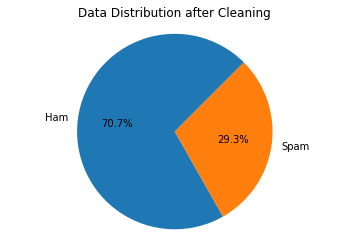


*****After Resampling Data*****
Total Number of E-Mails : 2926
Total Number of Ham E-Mails : 1463
Total Number of Spam E-Mails : 1463


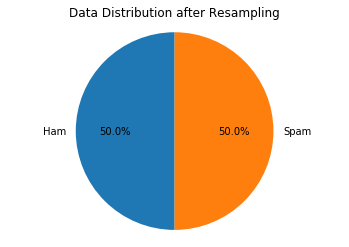




---------------- EXPLORATORY DATA ANALYSIS ----------------

The Top 20 Most Frequently Used Words in Ham Emails are:
1. ect
2. hou
3. enron
4. com
5. 2000
6. deal
7. gas
8. cc
9. meter
10. pm
11. hpl
12. daren
13. 2001
14. thanks
15. corp
16. 10
17. 01
18. 000
19. know
20. 00

Bar Plot to show their frequencies: 


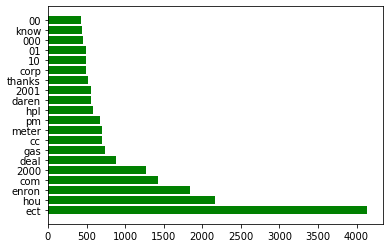


The Top 20 Most Frequently Used Words in Spam Emails are:
1. http
2. com
3. company
4. www
5. information
6. statements
7. nbsp
8. 00
9. email
10. price
11. new
12. td
13. time
14. pills
15. 99
16. free
17. font
18. investment
19. report
20. money

Bar Plot to show their frequencies


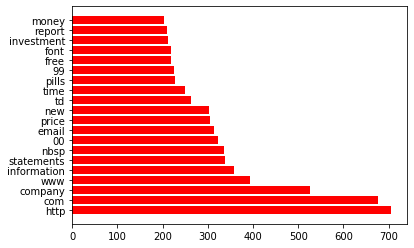


Box-Plot to show comparison between Ham and Spam Emails


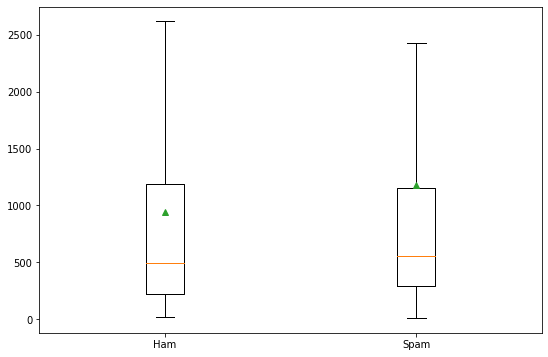


The Spam E-Mails are usually longer since the boxplot median is greater for Spam E-mails.
The mean value of the boxplot also confirms the same.

The maximum length of an E-Mail for both Spam and Ham are almost similar
This length is due to the multiple tab spaces in between messages.
Also, we can see that Spam E-Mails are longer because of the lucrative words, hyperlinks, malicious websites URL used in it.


************* MODEL PREDICTIONS *************

~~~~~~~~~~SVM RESULTS~~~~~~~~~~
Accuracy Score using SVM: 98.29
Precision Score using SVM: 100.00
F Score using SVM: 98.23

~~~~~~~~~~MNB RESULTS~~~~~~~~~~
Accuracy Score using MNB: 97.49
Precision Score using MNB: 99.04
F Score using MNB: 97.41




************* MODEL SELECTION *************

The below table shows the Accuracy, Recall and Precision Scores of SVM Model for different CV values:
      CV  Train Accuracy  Test Accuracy  Test Recall  Test Precision
0    1.0             1.0       0.982916     0.965278        1.000000
1    

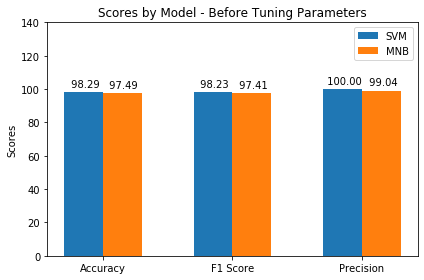

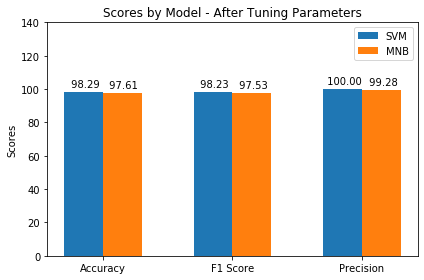



CONFUSION MATRIX for SVM Model:
             Predicted HAM  Predicted SPAM
Actual HAM             446               0
Actual SPAM             15             417


CONFUSION MATRIX for MNB Model:
             Predicted HAM  Predicted SPAM
Actual HAM             443               3
Actual SPAM             18             414


CONFUSION MATRIX - HEAT MAP for SVM Model


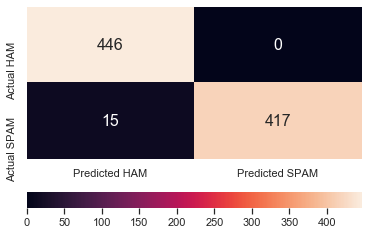

***** Receiver Operating Characteristic Curve *****

Area under the ROC curve : 0.9969



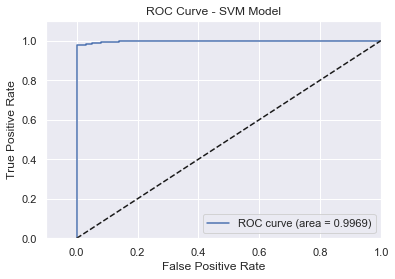

***** Precision-Recall Curve *****

SVM: f1-score=0.9812 AUC=0.9976


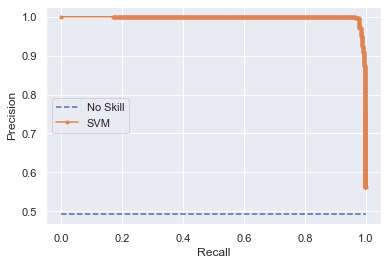

Total Execution Time : 38.28696250915527 seconds


In [14]:
def main():
    """---------Starting the timer to keep track of the execution times---------"""
    start_time = time.time()
    
    # Sets the file path for the root directory
    rootdir = "D:\\Notes - Canvas\\Semester-2\\Spam Detection"
    # Reads the files
    ham_list, spam_list = open_and_read_files(rootdir)
    # Cleans the data
    ham_cleaned_list, spam_cleaned_list = clean_list(ham_list, spam_list)
    # Removes the duplicate emails
    ham_unique_list, spam_unique_list = remove_duplicates(ham_cleaned_list, spam_cleaned_list)
    # Resampling Ham Data
    ham_resampled_list = resample(ham_unique_list,replace=False,n_samples=len(spam_unique_list),random_state=866)
    # Converts as dataframe
    emails_dataframe = convert_as_dataframe(ham_resampled_list, spam_unique_list)
    # Splits the data into train and test dataset in a ratio of 70:30
    message_train, message_test, class_train, class_test = split_data(emails_dataframe)
    # Feature Extraction 
    message_train_Feature, message_test_Feature = feature_extraction(message_train, message_test)
    # Exploratory Data Analysis
    sliced_ham, sliced_spam, list_ham, list_spam = eda(message_train, class_train)
    ham, spam = eda_comparison(list_ham, list_spam)
    # Converts the class as integers
    class_train_int = class_train.astype('int')
    class_test_int = class_test.astype('int')
    # Model Training & Prediction
    Pred_SVM, Pred_MNB = model_predictions(message_train_Feature, message_test_Feature, class_train_int)
    # SVM Model
    svm_model = model_SVM(message_train_Feature, message_test_Feature, class_train_int, class_test_int)
    # MNB Model
    mnb_model = model_MNB(message_train_Feature, message_test_Feature, class_train_int, class_test_int)
    # Model Evaluation
    roc_auc, fpr, tpr, f1, area_under_curve, no_skill, precision, recall = model_Evaluation(message_train_Feature, message_test_Feature, class_train_int, class_test_int)
    
    
    print("------------ STATISTICS ON TRAIN AND TEST DATASETS -------------")
    print("\n")
    print("*****Before Data Cleaning*****")
    total_count = len(ham_list)+len(spam_list)
    
    print("Total Number of E-Mails : " + str(total_count))
    print("Total Number of Ham E-Mails : " + str(len(ham_list)))
    print("Total Number of Spam E-Mails : " + str(len(spam_list)))
    
    print()
    print("*****After Data Cleaning*****")
    total_count_cleaned = len(ham_unique_list)+len(spam_unique_list)
    
    print("Total Number of E-Mails : " + str(total_count_cleaned))
    print("Total Number of Ham E-Mails : " + str(len(ham_unique_list)))
    print("Total Number of Spam E-Mails : " + str(len(spam_unique_list)))
    
    hamEmail_share = float(len(ham_unique_list)/total_count_cleaned)
    spamEmail_share = float(len(spam_unique_list)/total_count_cleaned)
    pieLabels='Ham', 'Spam'
    EmailDis = [hamEmail_share, spamEmail_share]
    figureObject, axesObject = plt.subplots()
    axesObject.pie(EmailDis,labels=pieLabels,autopct='%1.1f%%',startangle=45)
    axesObject.axis('equal')
    plt.title("Data Distribution after Cleaning")
    plt.show()
    
    print()
    print("*****After Resampling Data*****")
    total_count_resampled = len(ham_resampled_list)+len(spam_unique_list)
    
    print("Total Number of E-Mails : " + str(total_count_resampled))
    print("Total Number of Ham E-Mails : " + str(len(ham_resampled_list)))
    print("Total Number of Spam E-Mails : " + str(len(spam_unique_list)))
    
    hamEmail_share = float(len(ham_resampled_list)/total_count_resampled)
    spamEmail_share = float(len(spam_unique_list)/total_count_resampled)
    pieLabels='Ham', 'Spam'
    EmailDis = [hamEmail_share, spamEmail_share]
    figureObject, axesObject = plt.subplots()
    axesObject.pie(EmailDis,labels=pieLabels,autopct='%1.1f%%',startangle=90)
    axesObject.axis('equal')
    plt.title("Data Distribution after Resampling")
    plt.show()
    
    # Stores the resulting train and test dataset as csv files in local
    train_df = pd.concat([message_train, class_train], axis=1)
    train_df.to_csv('train_data.csv', sep=',', index=False)
    test_df = pd.concat([message_test, class_test], axis=1)
    test_df.to_csv('test_data.csv', sep=',', index=False)
    
    print("\n")
    print()
    print("---------------- EXPLORATORY DATA ANALYSIS ----------------")
    print()
    # Iterating through a dictionary of Frequently used words in both Ham and Spam dict
    ham_freq_words = []
    spam_freq_words = []
    for i,j in sliced_ham.items():
        ham_freq_words.append(i)
    
    for i,j in sliced_spam.items():
        spam_freq_words.append(i)
        
    print("The Top 20 Most Frequently Used Words in Ham Emails are:")
    count=0
    for i in ham_freq_words:
        count+=1
        print(count,". ",i,sep='')
    
    print()
    print("Bar Plot to show their frequencies: ")
    plt.barh(range(len(sliced_ham)), sliced_ham.values(), align='center', color='green')
    plt.yticks(range(len(sliced_ham)), list(sliced_ham.keys()))
    plt.show()
    
    print()
    print("The Top 20 Most Frequently Used Words in Spam Emails are:")
    count=0
    for i in spam_freq_words:
        count+=1
        print(count,". ",i,sep='')
    
    print()
    print("Bar Plot to show their frequencies")
    plt.barh(range(len(sliced_spam)), sliced_spam.values(), align='center', color='red')
    plt.yticks(range(len(sliced_spam)), list(sliced_spam.keys()))
    plt.show()
    
    print()
    print("Box-Plot to show comparison between Ham and Spam Emails")
    data_to_plot = [ham, spam]
    plt.figure(1, figsize=(9,6))
    plt.boxplot(data_to_plot, showfliers=False, showmeans=True)
    plt.xticks([1, 2], ['Ham', 'Spam'])
    plt.show()
    print()
    
    print("The Spam E-Mails are usually longer since the boxplot median is greater for Spam E-mails.", end='\n')
    print("The mean value of the boxplot also confirms the same.", end='\n')
    print()
    print("The maximum length of an E-Mail for both Spam and Ham are almost similar","This length is due to the multiple tab spaces in between messages.", sep='\n')
    print("Also, we can see that Spam E-Mails are longer because of the lucrative words, hyperlinks, malicious websites URL used in it.")
    print('\n')
    
    print("************* MODEL PREDICTIONS *************")
    print()
    print("~~~~~~~~~~SVM RESULTS~~~~~~~~~~")
    class_test_int = class_test_int.to_numpy()
    #Accuracy score using SVM
    print("Accuracy Score using SVM: {0:.2f}".format(accuracy_score(class_test_int, Pred_SVM)*100))
    print("Precision Score using SVM: {0:.2f}".format(precision_score(class_test_int, Pred_SVM)*100))
    print("F Score using SVM:{0: .2f}".format(f1_score(class_test_int, Pred_SVM)*100))
    
    svm_accuracy = accuracy_score(class_test_int, Pred_SVM)*100
    svm_precision = precision_score(class_test_int, Pred_SVM)*100
    svm_fscore = f1_score(class_test_int, Pred_SVM)*100

    print()
    print("~~~~~~~~~~MNB RESULTS~~~~~~~~~~")
    #Accuracy score using MNB
    print("Accuracy Score using MNB: {0:.2f}".format(accuracy_score(class_test_int, Pred_MNB)*100))
    print("Precision Score using MNB: {0:.2f}".format(precision_score(class_test_int, Pred_MNB)*100))
    print("F Score using MNB:{0: .2f}".format(f1_score(class_test_int, Pred_MNB)*100))
    
    mnb_accuracy = accuracy_score(class_test_int, Pred_MNB)*100
    mnb_precision = precision_score(class_test_int, Pred_MNB)*100
    mnb_fscore = f1_score(class_test_int, Pred_MNB)*100
    
    print('\n')
    print('\n')
    
    print("************* MODEL SELECTION *************")
    print()
    print("The below table shows the Accuracy, Recall and Precision Scores of SVM Model for different CV values:")
    print(svm_model)
    print()
    
    svm_loaded = pickle.load(open('spamfilter_SVM.sav', 'rb'))
    
    print("***** Support Vector Machine Model Scores after fine tuning parameters *****")
    print("Accuracy Score using SVM: {0:.2f}".format(accuracy_score(class_test_int, svm_loaded.predict(message_test_Feature))*100))
    print("Precision Score using SVM: {0:.2f}".format(precision_score(class_test_int, svm_loaded.predict(message_test_Feature))*100))
    print("F Score using SVM:{0: .2f}".format(f1_score(class_test_int, svm_loaded.predict(message_test_Feature))*100))
    print('\n')
    
    svm_accuracy_tuned = accuracy_score(class_test_int, svm_loaded.predict(message_test_Feature))*100
    svm_precision_tuned = precision_score(class_test_int, svm_loaded.predict(message_test_Feature))*100
    svm_fscore_tuned = f1_score(class_test_int, svm_loaded.predict(message_test_Feature))*100
    
    print("The below table shows the Accuracy, Recall and Precision Scores of MNB Model for different alpha values:")
    print(mnb_model.head(n=20))
    print()
    
    mnb_loaded = pickle.load(open('spamfilter_MNB.sav', 'rb'))
    
    print("***** Multinomial Naive Bayes Model Scores after fine tuning parameters *****")
    print("Accuracy Score using MNB: {0:.2f}".format(accuracy_score(class_test_int, mnb_loaded.predict(message_test_Feature))*100))
    print("Precision Score using MNB: {0:.2f}".format(precision_score(class_test_int, mnb_loaded.predict(message_test_Feature))*100))
    print("F Score using MNB:{0: .2f}".format(f1_score(class_test_int, mnb_loaded.predict(message_test_Feature))*100))
    
    mnb_accuracy_tuned = accuracy_score(class_test_int, mnb_loaded.predict(message_test_Feature))*100
    mnb_precision_tuned = precision_score(class_test_int, mnb_loaded.predict(message_test_Feature))*100
    mnb_fscore_tuned = f1_score(class_test_int, mnb_loaded.predict(message_test_Feature))*100
    
    ######### BAR PLOTS ###########
    # Before Tuning
    print('\n')
    print()
    labels = ['Accuracy', 'F1 Score', 'Precision']
    SVM = [svm_accuracy, svm_fscore, svm_precision]
    MNB = [mnb_accuracy, mnb_fscore, mnb_precision]

    x = np.arange(len(labels))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, SVM, width, label='SVM')
    rects2 = ax.bar(x + width/2, MNB, width, label='MNB')

    ax.set_ylabel('Scores')
    ax.set_title('Scores by Model - Before Tuning Parameters')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        """Attaches a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{0: .2f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.ylim([0, 140])
    plt.show()
    
    # After Tuning
    print()
    labels = ['Accuracy', 'F1 Score', 'Precision']
    SVM_tuned = [svm_accuracy_tuned, svm_fscore_tuned, svm_precision_tuned]
    MNB_tuned = [mnb_accuracy_tuned, mnb_fscore_tuned, mnb_precision_tuned]

    x = np.arange(len(labels))  # the label locations
    width = 0.3  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, SVM_tuned, width, label='SVM')
    rects2 = ax.bar(x + width/2, MNB_tuned, width, label='MNB')

    ax.set_ylabel('Scores')
    ax.set_title('Scores by Model - After Tuning Parameters')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{0: .2f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.ylim([0, 140])
    plt.show()
    
    print('\n')
    print("CONFUSION MATRIX for SVM Model:")
    svm_confusion_matrix = confusion_matrix(class_test_int, svm_loaded.predict(message_test_Feature))
    svm_conf_matrix = pd.DataFrame(data = svm_confusion_matrix, columns = ['Predicted HAM', 'Predicted SPAM'], index = ['Actual HAM', 'Actual SPAM'])
    print(svm_conf_matrix)
    
    print('\n')
    print("CONFUSION MATRIX for MNB Model:")
    mnb_confusion_matrix = confusion_matrix(class_test_int, mnb_loaded.predict(message_test_Feature))
    mnb_conf_matrix = pd.DataFrame(data = mnb_confusion_matrix, columns = ['Predicted HAM', 'Predicted SPAM'], index = ['Actual HAM', 'Actual SPAM'])
    print(mnb_conf_matrix)
    
    print('\n')
    
    print("CONFUSION MATRIX - HEAT MAP for SVM Model")
    sn.set(font_scale=1) # for label size
    sn.heatmap(svm_conf_matrix, annot=True, fmt="d", annot_kws={"size": 16}, cbar_kws={"orientation": "horizontal"}) # font size
    plt.show()
    
    print("***** Receiver Operating Characteristic Curve *****")
    print()
    print("Area under the ROC curve : %0.4f" % roc_auc)
    print()
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.1, 1.0])
    plt.ylim([0.0, 1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - SVM Model')
    plt.legend(loc="lower right")
    plt.show()
    
    print("***** Precision-Recall Curve *****")
    print()
    print('SVM: f1-score=%.4f AUC=%.4f' % (f1, area_under_curve))
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='SVM')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

    print("Total Execution Time : " + str(time.time() - start_time) + " seconds")
if __name__ == "__main__":
    main()

<font size="4"><strong>Model Classification, Selection & Evaluation:</strong></font><br><br>
After <b>Feature Extraction</b> from the training dataset, two different models, <font color="Red"><b>Linear Support Vector Classification and Multinomial Naive Bayes</b></font> are chosen and trained to fit the dataset.<br><br>
The accuracy of both the models are determined without any fine tuning the parameters.<br>
<b>Accuracy Score using SVM: 98.29</b><br>
<b>Accuracy Score using MNB: 97.49</b><br>

Now, both the models are fine tuned for different hyperparameters and the scores for each 'k'-fold Cross Validation and for each alpha value are tabulated.<br>

<font color="Green"><strong> The aim of the model is to predict whether an E-Mail is Spam or Non-Spam. No Model can give 100% Accuracy in prediction.<br></strong></font>
But, the misclassification should be a manageable option.<br><br>
<font color="Red"><strong>A Spam E-Mail can be classified as a Ham E-Mail but Ham E-Mail classified as Spam E_mail may go unnoticed which will result in some important information being undelivered to the end user.<br></strong></font>Therefore, A Model must be chosen in such a way that it has the <b>maximum</b> <font color="Red"><b>"Precision Score"</b></font> followed by other factors.

So, the best CV or alpha value is chosen based on the above logic and the models are fine tuned with the selected values.

After hyper-parameter selection on models, the scores are calculated as below:<br>

<font color="Red"><b> *   SVM Model  *</b></font><br>
<b>Accuracy Score using SVM: 98.29</b><br>
<b>Precision Score using SVM: 100.00</b><br>
<b>F Score using SVM: 98.23</b><br>

<font color="Red"><b> *   MNB Model  *</b></font><br>
<b>Accuracy Score using MNB: 97.61</b><br>
<b>Precision Score using MNB: 99.28</b><br>
<b>F Score using MNB: 97.53</b><br>
    
From the above scores, we can conclude that <b>*SVM based Model has 100% Precision and better accuracy than MNB based Model.*</b><br>
So, we can chose <font color="Red"><b>Support Vector Machine</b></font> model as the <b>most effective model</b> for evaluation.
    
<font color="Green"><b>From the Confusion Matrix - Heat Map of SVM Model, we can see that 446 Ham E-Mails are correctly classified as Ham, 417 Spam E-Mails are correctly classified as Spam and 15 Spam E-Mails are misclassified as Ham E-Mails.<br></b></font>
<font color="Red"><b>But, None of the Ham E-Mails are misclassified as Spam, which is the best output we can expect from a classification model.</b></font>

To understand how the model performs in comparison with no skill model (random guess predictions of 50%), an ROC (Receiver Operating Chracteristic) curve is plotted for sensitivity (True Positive Rate - ratio of actual positives that are correctly classified) against specificity (1-False Positive Rate or True Negative Rate - ratio of actual negatives that are correctly classified).
    
<font color="Purple"><b> Area under the ROC curve : 0.9969 </b></font>

<b>SVM model's AUC is around 99.69% which is a very good value indicating excellent performance in classifying the E-Mails.</b>
    
<b>F1 score</b> - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. F1 is usually more useful than accuracy, especially if the dataset has an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. 

<font color="Red"><b>F1 Score = 2*(Recall * Precision) / (Recall + Precision)</b></font>
    
In SVM Model used, <font color="Purple"><b>F1 score is 0.9812</b></font>
    
Since the dataset used has even distribution and not biased, the <b>Accuracy and F1-Score is almost the same.</b>


<font size="4"><strong>References:</strong></font><br>

[1]	 A. A. Alurkar et al., “A proposed data science approach for email spam classification using machine learning techniques,” in 2017 Internet of Things Business Models, Users, and Networks, Nov. 2017, pp. 1–5, doi: 10.1109/CTTE.2017.8260935.

[2]	 randerson112358, “Email Spam Detection Using Python & Machine Learning,” Medium, Aug. 08, 2019. https://medium.com/@randerson112358/email-spam-detection-using-python-machine-learning-abe38c889855 (accessed Apr. 04, 2020).

[3]	 “Email Spam Filtering: An Implementation with Python and Scikit-learn,” KDnuggets. https://www.kdnuggets.com/email-spam-filtering-an-implementation-with-python-and-scikit-learn.html/ (accessed Apr. 04, 2020).

[4]	 “Imbalanced Data,” Google Developers. https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data (accessed Apr. 04, 2020).

[5]	 “sklearn.utils.resample — scikit-learn 0.22.2 documentation.” https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html (accessed Apr. 04, 2020).

[6]	 “API Reference — scikit-learn 0.22.2 documentation.” https://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm (accessed Apr. 04, 2020).

[7]	 J. Brownlee, “How to Use ROC Curves and Precision-Recall Curves for Classification in Python,” Machine Learning Mastery, Aug. 30, 2018. https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/ (accessed Apr. 04, 2020).

<font size="4"><strong>Appendix:</strong></font><br><br>
The code has a <b>main()</b> function which has all the methods to be invoked.  
The entire <b>.ipynb file</b> has to be run to get the desired findings and outputs.<br><b>All tables, findings, visualizations, plots are available at the main() function for reference.</b><br><br>
Each method is explained clearly, with the parameters passed and what the method returns. Also, the objective of each method is clearly explained at the end of the method. At the end of main() function, the model classification, selection and evaluation is discussed in details. <b>The report has been referenced using IEEE Referencing Style.</b>